In [94]:
import importlib

importlib.reload(data_collection)
from data_collection import mask_no_labeled_pixel_all_zones
from data_collection import generate_monthly_ranges


from data_collection import get_median_image
import geemap

In [ ]:
# Load the shapefile containing the parcels
gdf = gpd.read_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")
gdf  = gdf.to_crs(epsg=4326)
Label_culture = pd.read_csv("../data/REF_CULTURES_GROUPES.csv", sep=";")
Label_culture["Label"] = pd.to_numeric(Label_culture["Label"], errors="coerce").astype("Int64")
Label_culture["Label"] = Label_culture["Label"].fillna(0).astype(int)
gdf = gdf.merge(Label_culture[["Label","CODE_CULTURE"]], how="left", left_on="CODE_CULTU", right_on="CODE_CULTURE") #TODO check if this is right (CODE_CULTU)
gdf = gdf.rename(columns={"Label": "LABEL"})
gdf.to_file("/Users/placiermoise/Documents/dsw_proj/Parcelles/RPG_2023/PARCELLES_GRAPHIQUES.gpkg", driver="GPKG")


In [95]:
gdf

ModuleNotFoundError: No module named 'pandas.io.formats.string'

ModuleNotFoundError: No module named 'pandas.io.formats.html'

In [16]:
ee.Authenticate(scopes=['https://www.googleapis.com/auth/earthengine',
                        'https://www.googleapis.com/auth/drive'])
ee.Initialize()

In [45]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [46]:
coordinates = []
for feature in Map.draw_features:
        coordinate = feature.geometry().getInfo()
        coordinates.append(coordinate['coordinates'])
coordinates  

[[1.384277, 49.138597],
 [6.196289, 48.341646],
 [1.054688, 46.21025],
 [0.131836, 44.918139],
 [4.987793, 45.981695],
 [4.21875, 48.57479],
 [-0.791016, 48.545705]]

[[0.472412, 44.504341],
 [0.692139, 46.149394],
 [5.218506, 45.413876],
 [1.450195, 48.166085]]

In [47]:
coords_list = coordinates

List_Geometry_data_collect = create_gee_geometries(coords_list, side_km=10)

i=0
for geometry in List_Geometry_data_collect :
    i+=1
    Map.addLayer(geometry, {}, f"zone{i}")

Map


Map(bottom=6043.0, center=[47.29413372501023, 6.8115234375], controls=(WidgetControl(options=['position', 'tra…

In [90]:
start_date = '2023-01-01'
end_date = '2023-12-31'

#ranges = generate_half_month_ranges(start_date, end_date)
ranges = generate_monthly_ranges(start_date, end_date)
ranges

[('2023-01-01', '2023-02-01'),
 ('2023-02-01', '2023-03-01'),
 ('2023-03-01', '2023-04-01'),
 ('2023-04-01', '2023-05-01'),
 ('2023-05-01', '2023-06-01'),
 ('2023-06-01', '2023-07-01'),
 ('2023-07-01', '2023-08-01'),
 ('2023-08-01', '2023-09-01'),
 ('2023-09-01', '2023-10-01'),
 ('2023-10-01', '2023-11-01'),
 ('2023-11-01', '2023-12-01'),
 ('2023-12-01', '2023-12-31')]

In [48]:


zone_number = 0

for geometry in List_Geometry_data_collect : 

    zone_number += 1

    # Create a list of median images for each date range
    median_images = [get_median_image(start, end, geometry) for start, end in ranges]

    # Create a collection from the images
    image_collection = ee.ImageCollection(median_images)

    folderName = f'GEE_export_zone{zone_number}'

    # export to TIFF format
    export_folder = str(folderName)
    export_maxPixels = 1e10
    
    export_tiff(image_collection,geometry,export_folder,export_maxPixels )

###############################################################################################
######### moove Zone folder of tif  from drive to ../data/tif     !!!!!!!!!!!! ################
###############################################################################################

Export started for image 1/13, date : 20230101
Export started for image 2/13, date : 20230131
Export started for image 3/13, date : 20230302
Export started for image 4/13, date : 20230401
Export started for image 5/13, date : 20230501
Export started for image 6/13, date : 20230531
Export started for image 7/13, date : 20230630
Export started for image 8/13, date : 20230730
Export started for image 9/13, date : 20230829
Export started for image 10/13, date : 20230928
Export started for image 11/13, date : 20231028
Export started for image 12/13, date : 20231127
Export started for image 13/13, date : 20231227
Export started for image 1/13, date : 20230101
Export started for image 2/13, date : 20230131
Export started for image 3/13, date : 20230302
Export started for image 4/13, date : 20230401
Export started for image 5/13, date : 20230501
Export started for image 6/13, date : 20230531
Export started for image 7/13, date : 20230630
Export started for image 8/13, date : 20230730
Export st

In [91]:
rasterize_labels_per_zone(base_dir="../data/Tif", gdf=gdf, label_column="LABEL")

🔄  processing zone n°: zone6
✅ ground trouth label saved : ../data/Tif/zone6/labels_raster.tif
🔄  processing zone n°: zone1
✅ ground trouth label saved : ../data/Tif/zone1/labels_raster.tif
🔄  processing zone n°: zone7
✅ ground trouth label saved : ../data/Tif/zone7/labels_raster.tif
🔄  processing zone n°: zone2
✅ ground trouth label saved : ../data/Tif/zone2/labels_raster.tif
🔄  processing zone n°: zone5
✅ ground trouth label saved : ../data/Tif/zone5/labels_raster.tif
🔄  processing zone n°: zone4
✅ ground trouth label saved : ../data/Tif/zone4/labels_raster.tif
🔄  processing zone n°: zone3
✅ ground trouth label saved : ../data/Tif/zone3/labels_raster.tif


In [92]:

base_dir = "../data/Tif"
mask_no_labeled_pixel_all_zones(base_dir)


🔄 Masking TIFFs in zone: zone6


Masking TIFFs in zone6: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


✅ Masking done for zone zone6
🔄 Masking TIFFs in zone: zone1


Masking TIFFs in zone1: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


✅ Masking done for zone zone1
🔄 Masking TIFFs in zone: zone7


Masking TIFFs in zone7: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


✅ Masking done for zone zone7
🔄 Masking TIFFs in zone: zone2


Masking TIFFs in zone2: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s]


✅ Masking done for zone zone2
🔄 Masking TIFFs in zone: zone5


Masking TIFFs in zone5: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


✅ Masking done for zone zone5
🔄 Masking TIFFs in zone: zone4


Masking TIFFs in zone4: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


✅ Masking done for zone zone4
🔄 Masking TIFFs in zone: zone3


Masking TIFFs in zone3: 100%|██████████| 1/1 [00:00<00:00, 49.62it/s]

✅ Masking done for zone zone3


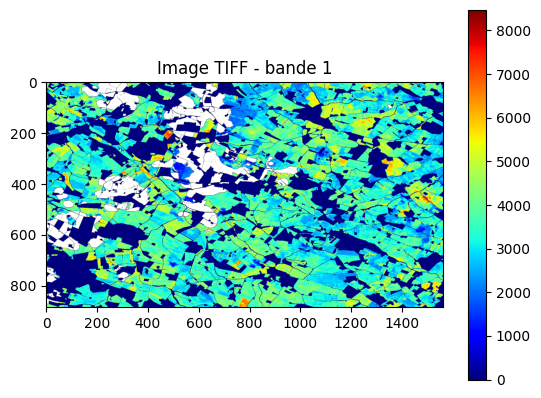

In [74]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open("/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/data/Tif/zone1/sentinel2_20230501_masked.tif") as src:
    img = src.read(4) 

plt.imshow(img, cmap='jet')  # or 'viridis', 'jet', etc.
plt.colorbar()
plt.title('Image TIFF - bande 1')
plt.show()